In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [3]:
import nltk
nltk.download("names")
nltk.download("wordnet")
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package names to /Users/jongwon/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jongwon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [5]:
from wordcloud import WordCloud, STOPWORDS

In [6]:
# dataset: http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz
# nb source: https://kbig.kr/portal/kbig/datacube/onl_edu_class/python?bltnNo=11583391864803
# spam/ham labeled email, spam:1, ham:0
emails, labels =[], []

paths = ["enron1/spam/", "enron1/ham/"]
for path in paths:
    for filename in glob.glob(os.path.join(path, "*.txt")):
        with open(filename, "r", encoding="ISO-8859-1") as file:
            emails.append(file.read())
            if path.endswith("spam/"):
                labels.append(1)
            else:
                labels.append(0)

In [7]:
len(emails), len(labels)

(5172, 5172)

In [8]:
labels.count(1), labels.count(0)

(1500, 3672)

In [9]:
# pre-processing lemmatize, is_alpha, not human name, not month name
human_names = set(names.words())
lemmatizer = WordNetLemmatizer()
lowered_human_names = [x.lower() for x in human_names]
lowered_month_names = ['jan', 'january', 'feb', 'february', 'mar', 'march', 'apr', 'april', 'may', 'june',
                       'july', 'aug', 'august', 'sept', 'september', 'oct', 'october', 'nov', 'november', 'dec', 'december']

In [10]:
def preprocess(emails):
    corpus = []
    for email in emails:
        corpus.append(" ".join([lemmatizer.lemmatize(word.lower())
                                for word in email.split()
                                if word.isalpha()
                                and word not in lowered_human_names
                                and word not in lowered_month_names
                               ]))
    return corpus

In [12]:
corpus = preprocess(emails) #takes long

In [111]:
def NB(corpus,alpha,fit_prior):
    DATA = corpus
    vectorizer = CountVectorizer(stop_words="english", max_features=500)
    term_docs = vectorizer.fit_transform(DATA)
    term_docs.toarray()
    feature_names = vectorizer.get_feature_names()
    #print(vectorizer.vocabulary_)
    
    X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.3, random_state=20)
    len(X_train), len(y_train), len(X_test), len(y_test)
    term_docs_train = vectorizer.fit_transform(X_train)
    term_docs_test = vectorizer.transform(X_test)

    naive_bayes = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    naive_bayes.fit(term_docs_train, y_train)
    y_pred = naive_bayes.predict(term_docs_test)
    y_pred_proba = naive_bayes.predict_proba(term_docs_test)
    np.unique(y_pred, return_counts=True)
    
    #draw ROCAUC
    fpr, tpr, _ =roc_curve(y_test, y_pred_proba[:, 1])
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    plt.plot(fpr, tpr, "r-", label="MultinomialNB")
    plt.plot([0, 1], [0, 1], "b--", label="random guessing")
    plt.title("AUC={:.4f}".format(auc))
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()

    return naive_bayes.score(term_docs_test, y_test), auc

(0.9259020618556701, 0.9645396432436959)

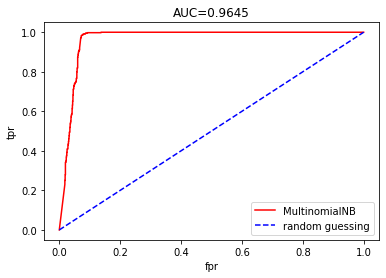

In [37]:
NB(emails, 1, True)

(0.9213917525773195, 0.9608590615264099)

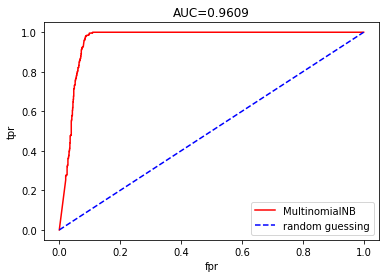

In [112]:
NB(corpus, 1, True) #with filtering non-words

In [49]:
#nb score is 0.9259 without preprocessing, auc score is 0.9645 without preprocessing
#nb score is 0.9214 with preprocessing, auc score is 0.9609 with preprocessing
#model performance drops with preprocessing

In [41]:
#finding best hyper params

In [42]:
parameters = {
    "alpha": [0.5, 1.0, 1.5, 2.0],
    "fit_prior": [True, False]
}

In [43]:
grid_search = GridSearchCV(naive_bayes, parameters, n_jobs=-1, cv=10, scoring="roc_auc")
grid_search.fit(term_docs_train, y_train)
grid_search.best_params_

{'alpha': 0.5, 'fit_prior': False}

In [44]:
#previously: 'alpha': 1, 'fit_prior': True
#best params: 'alpha': 0.5, 'fit_prior': False

(0.9246134020618557, 0.9616025529862244)

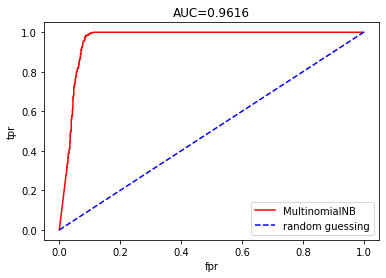

In [48]:
NB(corpus, .5, False) #with preprocessing, with best params

In [50]:
#nb score is 0.9214 with preprocessing, auc score is 0.9609 with preprocessing with alpha = 1, fit_prior = True
#nb score is 0.9246 with preprocessing, auc score is 0.9616 with preprocessing with alpha = 1, fit_prior = True
#model performance enhanced with best params alpha = .5, fit_prior = False

(0.9439432989690721, 0.9663036913454006)

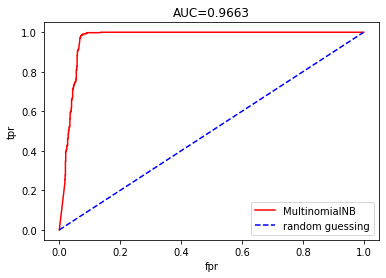

In [113]:
#nb test without preprocessing
NB(emails, .5, False)

In [114]:
#gives the best result.

In [51]:
stopwords = set(STOPWORDS)
stopwords.update([])
# wordcloud source: https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

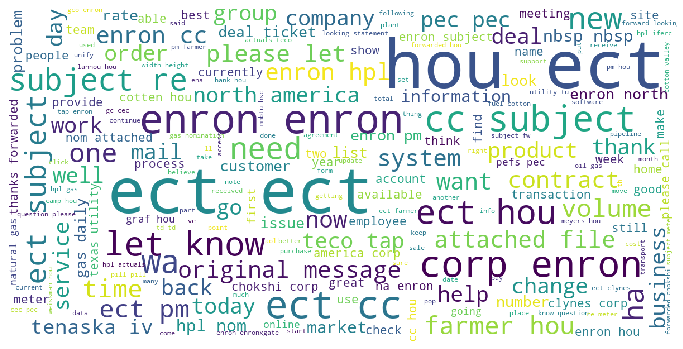

In [52]:
show_wordcloud(corpus)

In [53]:
#additional stopwords from word cloud
additional_stopwords = ['hou','wa','nom', 'hpl', 'noms', 've', 'ha', 'll', 'jones', 'cc', 're', 'td', 'width',
                        'iv', 'ena', 'nbsp', 'hplc', 'ce', 'th', 'aep', 'gc', 'cec', 'pec', 'ect', 'enron']
stopwords = set(STOPWORDS)
stopwords.update(additional_stopwords)

#update corpus to updated_corpus
updated_corpus = []
for email in corpus:
    updated_corpus.append(" ".join(word for word in email.split() if word not in stopwords))

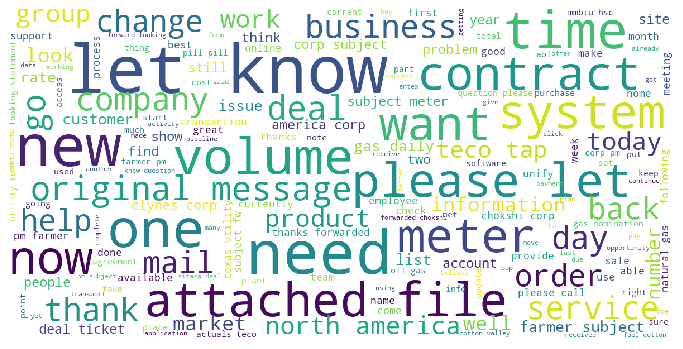

In [54]:
show_wordcloud(updated_corpus)

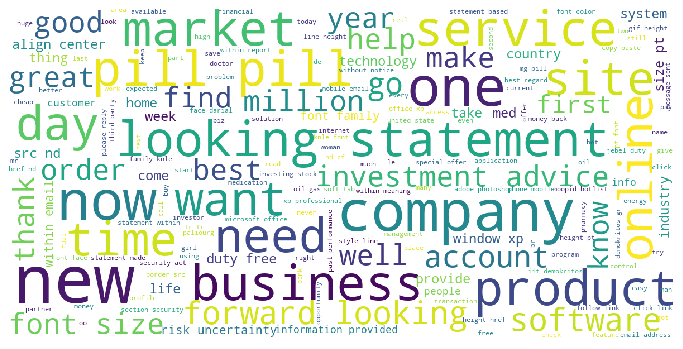

In [55]:
#spam
show_wordcloud(updated_corpus[:1499])

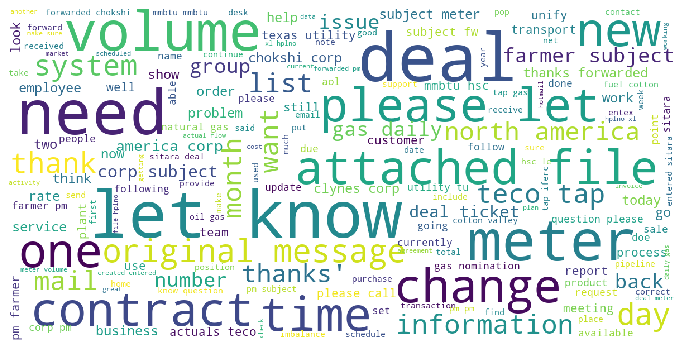

In [56]:
#ham
show_wordcloud(updated_corpus[1500:])

(0.9246134020618557, 0.9616025529862244)

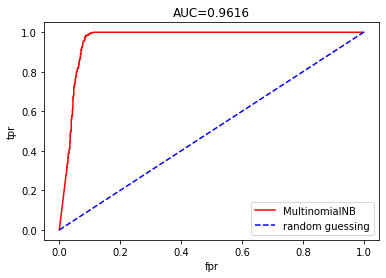

In [57]:
NB(corpus, .5, False)

(0.9246134020618557, 0.9655263142158358)

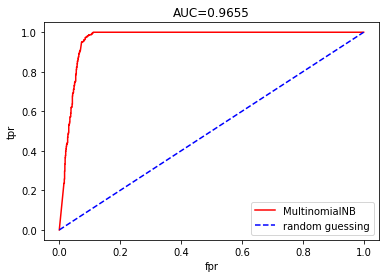

In [58]:
NB(updated_corpus, .5, False)

In [73]:
#personal email
data = pd.read_csv('spamham.csv')

In [74]:
personal_email = data['mail'].to_list()
personal_email_label = data['label'].to_list()

In [75]:
pp_personal_email = preprocess(personal_email)

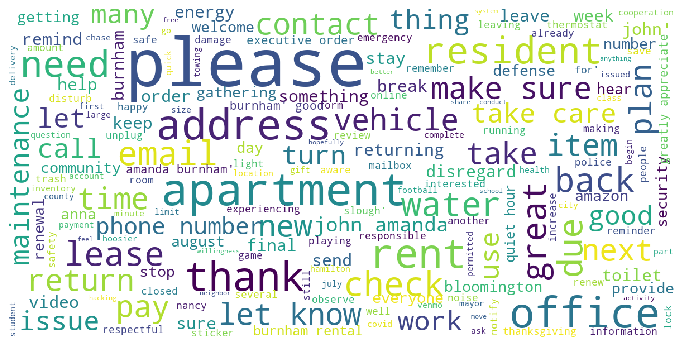

In [77]:
# ham
show_wordcloud(pp_personal_email[:13])

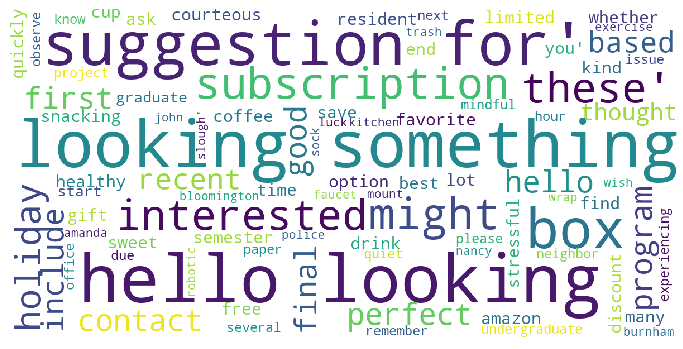

In [78]:
# spam
show_wordcloud(pp_personal_email[13:])

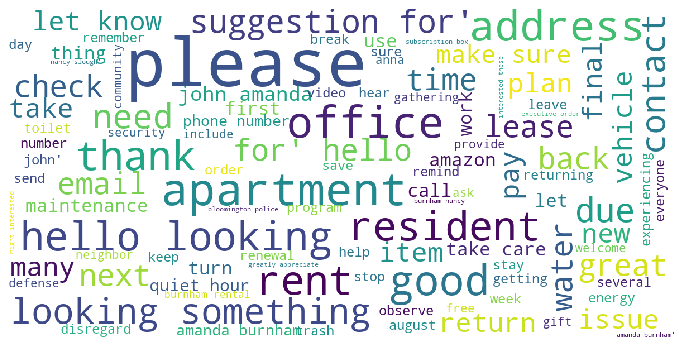

In [79]:
# personal email corpus
show_wordcloud(pp_personal_email)

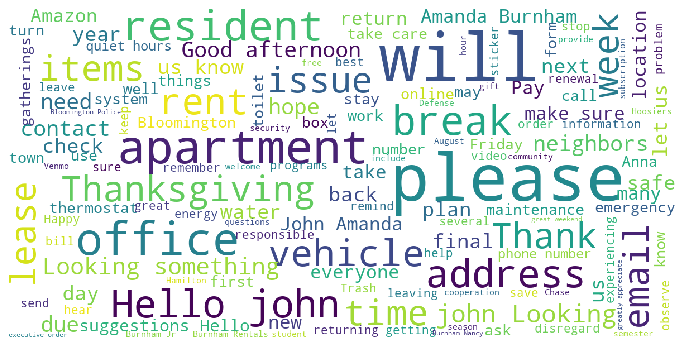

In [66]:
# not pre-processed personal email corpus
show_wordcloud(personal_email)

In [115]:
DATA = updated_corpus
alpha=.5
fit_prior=False

vectorizer = CountVectorizer(stop_words="english", max_features=500)
term_docs = vectorizer.fit_transform(DATA)
term_docs.toarray()
feature_names = vectorizer.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.3, random_state=20)
len(X_train), len(y_train), len(X_test), len(y_test)
term_docs_train = vectorizer.fit_transform(corpus)
#testing preprocessed personal email
term_docs_test = vectorizer.transform(pp_personal_email)

naive_bayes = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
naive_bayes.fit(term_docs_train, labels)
naive_bayes.score(term_docs_test, personal_email_label)

0.5

In [116]:
#testing personal email without pre-processing
term_docs_test = vectorizer.transform(personal_email)

naive_bayes = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
naive_bayes.fit(term_docs_train, labels)
naive_bayes.score(term_docs_test, personal_email_label)

0.5416666666666666

In [110]:
# NB model trained with the enron dataset fails to classify personal dataset
# NB score drops even more after preprocessing the personal data